# ML Model for All 500,000 Grids (The Oracle Builder)

* Refinement: Do not just build one ML model; focus on building four high-accuracy models (one for each advisor) and using an AutoML tool (like AutoGluon or a deep ensemble) for robustness.
* Key Action: Feature Engineering is Paramount. Focus heavily on creating spatial features (adjacencies, proximity, density) that the advisors likely use.


In [1]:
# Setup and Data Loading
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# Clone repository if not exists and load data
if not os.path.exists('2155-Challenge-Problem-2'):
    import subprocess
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/Lyleregenwetter/2155-Challenge-Problem-2'], 
                   check=True, cwd='.')
    print("Repository cloned!")

# Change to the repository directory and load data
os.chdir('2155-Challenge-Problem-2')

# Import utilities
from utils_public import load_grids, plot_n_grids

print("Loading data...")
grids = load_grids()
ratings = np.load("datasets/scores.npy")

print(f"Grids shape: {grids.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"Available ratings per advisor: {(~np.isnan(ratings)).sum(axis=0)}")

advisor_names = ["Wellness", "Tax", "Transportation", "Business"]

# Change back to parent directory for saving results
os.chdir('..')

Loading data...
Grids shape: (500000, 7, 7)
Ratings shape: (500000, 4)
Available ratings per advisor: [5000 5000 5000 5000]
Grids shape: (500000, 7, 7)
Ratings shape: (500000, 4)
Available ratings per advisor: [5000 5000 5000 5000]


In [2]:
# Check PyTorch availability for CNN models
print("🔍 Checking PyTorch environment...")
try:
    import torch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ PyTorch available - Device: {device}")
    if torch.cuda.is_available():
        print(f"   🚀 CUDA detected: {torch.cuda.get_device_name(0)}")
    else:
        print(f"   💻 Using CPU for CNN training")
except ImportError:
    print("❌ PyTorch not found - CNN models will not work")
    print("   Install with: pip install torch torchvision")

print(f"{'='*50}")

🔍 Checking PyTorch environment...
✅ PyTorch available - Device: cpu
   💻 Using CPU for CNN training
✅ PyTorch available - Device: cpu
   💻 Using CPU for CNN training


In [3]:
# Load pre-trained Oracle models from pickle files
import os
from oracle import CNNTransportationOracle, CNNWellnessOracle
from oracle import CNNBusinessOracle, CNNTaxOracle

print("🔄 Loading pre-trained Oracle models from pickle files...")

# Define available oracle classes with corrected advisor order: ["Wellness", "Tax", "Transportation", "Business"]
oracle_classes = {
    'Wellness': CNNWellnessOracle,      # Advisor 0 - uses CityCNN1Plus (deep)
    'Tax': CNNTaxOracle,                # Advisor 1 - uses CityCNN1 (standard)
    'Transportation': CNNTransportationOracle,  # Advisor 2 - uses CityCNN1Plus (deep) 
    'Business': CNNBusinessOracle       # Advisor 3 - uses CityCNN1 (standard)
}

# Initialize oracles
oracle_files = {
    'Wellness': 'data/models/wellness_oracle_model.pkl',
    'Tax': 'data/models/tax_oracle_model.pkl',
    'Transportation': 'data/models/transportation_oracle_model.pkl',
    'Business': 'data/models/business_oracle_model.pkl'
}

# Load available pre-trained models
loaded_models = {}
for advisor_name, filename in oracle_files.items():
    if os.path.exists(filename):
        print(f"📁 Loading {advisor_name} Oracle from {filename}...")
        try:
            # Create oracle instance using the appropriate class
            oracle_class = oracle_classes[advisor_name]
            oracle = oracle_class()
            oracle.load_model(filename)
            
            loaded_models[advisor_name] = oracle
            print(f"✅ {advisor_name} Oracle loaded successfully!")
        except Exception as e:
            print(f"❌ Failed to load {advisor_name} Oracle: {e}")
            print(f"   Error details: {type(e).__name__}")
    else:
        print(f"⚠️  {filename} not found - will need fallback for {advisor_name}")

print(f"\n📊 Successfully loaded {len(loaded_models)} pre-trained models:")
for advisor_name in loaded_models.keys():
    oracle = loaded_models[advisor_name]
    advisor_id = getattr(oracle, 'advisor_id', 'Unknown')
    architecture = "CityCNN1Plus (deep)" if advisor_id in [0, 2] else "CityCNN1 (standard)"
    print(f"   ✓ {advisor_name} Oracle (Advisor {advisor_id}) - {architecture}")

# Create a combined predictor class for easy use
class PreTrainedOraclePredictor:
    def __init__(self, loaded_models):
        self.loaded_models = loaded_models
        self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]  # Corrected order
        
    def predict_advisor(self, grids, advisor_idx):
        """Predict using pre-trained model for specific advisor"""
        advisor_name = self.advisor_names[advisor_idx]
        
        if advisor_name in self.loaded_models:
            oracle = self.loaded_models[advisor_name]
            print(f"🔮 Predicting with {advisor_name} Oracle...")
            return oracle.predict(grids)
        else:
            print(f"⚠️  No pre-trained model for {advisor_name}, returning zeros")
            return np.zeros(len(grids))
    
    def predict_all_advisors(self, grids):
        """Predict for all advisors using available pre-trained models"""
        print(f"🚀 Generating predictions for all advisors...")
        predictions = []
        for advisor_idx in range(4):
            advisor_predictions = self.predict_advisor(grids, advisor_idx)
            predictions.append(advisor_predictions)
        return np.stack(predictions).T

# Initialize the combined predictor
oracle_predictor = PreTrainedOraclePredictor(loaded_models)
print(f"✅ Pre-trained Oracle predictor ready!")
print(f"🎯 Can predict for {len(loaded_models)} advisors without training")
print(f"🧠 Architecture mapping:")
print(f"   • Wellness (0) & Transportation (2): CityCNN1Plus (deep)")
print(f"   • Tax (1) & Business (3): CityCNN1 (standard)")

🔄 Loading pre-trained Oracle models from pickle files...
📁 Loading Wellness Oracle from data/models/wellness_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/wellness_oracle_model_pytorch.pth
✅ Wellness Oracle loaded successfully!
📁 Loading Tax Oracle from data/models/tax_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/tax_oracle_model_pytorch.pth
✅ Tax Oracle loaded successfully!
📁 Loading Transportation Oracle from data/models/transportation_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/wellness_oracle_model_pytorch.pth
✅ Wellness Oracle loaded successfully!
📁 Loading Tax Oracle from data/models/tax_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/tax_oracle_model_pytorch.pth
✅ Tax Oracle loaded successfully!
📁 Loading Transportation Oracle from data/models/transportation_oracle_mode

In [4]:
# Generate predictions using pre-trained Oracle models (SMALL SUBSET for speed)
print("🚀 Generating Oracle predictions using pre-trained models...")
print("⚡ Using small subset of grids for faster processing...")

# Use much smaller subset for faster processing
subset_size = 500000  # Reduced from 100,000 to 10,000
print(f"📊 Processing {subset_size:,} grids (subset of {len(grids):,} total)")

# Create random subset for representative sampling
np.random.seed(42)  # For reproducibility
subset_indices = np.random.choice(len(grids), size=subset_size, replace=False)
grids_subset = grids[subset_indices]
ratings_subset = ratings[subset_indices]

print(f"✅ Created subset: {grids_subset.shape}")

# Use the pre-trained predictor to generate predictions for subset
oracle_prediction_matrix_subset = oracle_predictor.predict_all_advisors(grids_subset)
print(f"Oracle predictions shape: {oracle_prediction_matrix_subset.shape}")

# Create full-size prediction matrix with NaN for non-predicted grids
oracle_prediction_matrix = np.full((len(grids), 4), np.nan)
oracle_prediction_matrix[subset_indices] = oracle_prediction_matrix_subset

# Merge with actual ratings where available (for full dataset)
final_oracle_predictions = oracle_prediction_matrix.copy()
for advisor_idx in range(4):
    mask = ~np.isnan(ratings[:, advisor_idx])
    final_oracle_predictions[mask, advisor_idx] = ratings[mask, advisor_idx]

print("\n✅ Oracle predictions complete!")
print(f"Predictions generated for: {subset_size:,} grids")
print(f"Using actual ratings for: {(~np.isnan(ratings)).sum(axis=0)} samples per advisor")
print(f"Using Oracle predictions for: {(~np.isnan(oracle_prediction_matrix)).sum(axis=0)} samples per advisor")

# Quick quality check on predicted subset
print(f"\n📈 Prediction Quality Check (subset):")
for advisor_idx, advisor_name in enumerate(oracle_predictor.advisor_names):
    predictions = oracle_prediction_matrix_subset[:, advisor_idx]
    print(f"   • {advisor_name:15}: Range [{np.min(predictions):.3f}, {np.max(predictions):.3f}], Mean {np.mean(predictions):.3f}")

# Coverage analysis
total_with_data = (~np.isnan(final_oracle_predictions)).sum(axis=0)
print(f"\n📊 Data Coverage per Advisor:")
for advisor_idx, advisor_name in enumerate(oracle_predictor.advisor_names):
    coverage = total_with_data[advisor_idx]
    percentage = (coverage / len(grids)) * 100
    print(f"   • {advisor_name:15}: {coverage:,} grids ({percentage:.1f}% coverage)")

print(f"\n💾 Predictions ready for analysis and grid optimization!")
print(f"💡 Note: Using {subset_size:,} grid subset for faster processing")

# Save subset info for reference
np.save('data/submissions/oracle_subset_indices.npy', subset_indices)
print(f"📁 Saved subset indices to: data/submissions/oracle_subset_indices.npy")

🚀 Generating Oracle predictions using pre-trained models...
⚡ Using small subset of grids for faster processing...
📊 Processing 500,000 grids (subset of 500,000 total)

⚡ Using small subset of grids for faster processing...
📊 Processing 500,000 grids (subset of 500,000 total)
✅ Created subset: (500000, 7, 7)
🚀 Generating predictions for all advisors...
🔮 Predicting with Wellness Oracle...
Creating predictions for 500000 grids...
✅ Created subset: (500000, 7, 7)
🚀 Generating predictions for all advisors...
🔮 Predicting with Wellness Oracle...
Creating predictions for 500000 grids...
🔮 Predicting with Tax Oracle...
Creating predictions for 500000 grids...
🔮 Predicting with Tax Oracle...
Creating predictions for 500000 grids...
🔮 Predicting with Transportation Oracle...
Creating predictions for 500000 grids...
🔮 Predicting with Transportation Oracle...
Creating predictions for 500000 grids...
🔮 Predicting with Business Oracle...
Creating predictions for 500000 grids...
🔮 Predicting with B

In [5]:
# Analyze the Oracle results (working with subset data)
print("🔍 Analyzing Oracle Results...")

# Since we used a subset, we need to analyze differently
# Extract only the grids where we have predictions (non-NaN values)
valid_prediction_mask = ~np.isnan(oracle_prediction_matrix).any(axis=1)
valid_prediction_indices = np.where(valid_prediction_mask)[0]

print(f"📊 Analysis based on {len(valid_prediction_indices):,} grids with predictions")

# Get predictions for grids that have Oracle predictions
subset_predictions = final_oracle_predictions[valid_prediction_mask]
subset_grids = grids[valid_prediction_mask]

print(f"Subset predictions shape: {subset_predictions.shape}")

# Calculate min scores for the subset with predictions
min_scores_subset = np.min(subset_predictions, axis=1)

# Create full arrays with NaN for compatibility
min_scores = np.full(len(grids), np.nan)
min_scores[valid_prediction_mask] = min_scores_subset

valid_mask = np.full(len(grids), False)
threshold = 0.75
valid_subset_mask = min_scores_subset >= threshold
valid_mask[valid_prediction_mask] = valid_subset_mask

print(f"\n{'='*60}")
print("ORACLE PERFORMANCE ANALYSIS (SUBSET)")
print(f"{'='*60}")

print(f"\n📊 VALIDITY ANALYSIS:")
print(f"   • Total grids with predictions: {len(subset_predictions):,}")
print(f"   • Valid grids (min score ≥ {threshold}): {np.sum(valid_subset_mask):,}")
print(f"   • Validity rate: {np.sum(valid_subset_mask)/len(subset_predictions)*100:.2f}%")

print(f"\n📈 SCORE DISTRIBUTION (SUBSET):")
advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
for i, advisor in enumerate(advisor_names):
    advisor_scores = subset_predictions[:, i]
    print(f"   • {advisor:15}: Range [{np.min(advisor_scores):.3f}, {np.max(advisor_scores):.3f}], Mean {np.mean(advisor_scores):.3f}")

print(f"\n🏆 BEST PERFORMING GRIDS (SUBSET):")
if np.sum(valid_subset_mask) > 0:
    best_indices = np.argsort(min_scores_subset[valid_subset_mask])[-5:]  # Top 5
    print(f"Top 5 minimum scores: {min_scores_subset[valid_subset_mask][best_indices]}")
else:
    print("   • No grids meet the validity threshold in this subset")

print(f"\n💡 Note: Analysis based on {len(subset_predictions):,} grid subset")
print(f"📊 For full dataset analysis, would need to run predictions on all 500K grids")

🔍 Analyzing Oracle Results...
📊 Analysis based on 500,000 grids with predictions
Subset predictions shape: (500000, 4)

ORACLE PERFORMANCE ANALYSIS (SUBSET)

📊 VALIDITY ANALYSIS:
   • Total grids with predictions: 500,000
   • Valid grids (min score ≥ 0.75): 693
   • Validity rate: 0.14%

📈 SCORE DISTRIBUTION (SUBSET):
   • Wellness       : Range [0.000, 1.205], Mean 0.503
   • Tax            : Range [-0.111, 1.240], Mean 0.504
   • Transportation : Range [0.000, 1.253], Mean 0.473
   • Business       : Range [-0.145, 1.205], Mean 0.503

🏆 BEST PERFORMING GRIDS (SUBSET):
Top 5 minimum scores: [0.96615517 0.96985704 0.97085816 0.97101957 0.97211438]

💡 Note: Analysis based on 500,000 grid subset
📊 For full dataset analysis, would need to run predictions on all 500K grids
Subset predictions shape: (500000, 4)

ORACLE PERFORMANCE ANALYSIS (SUBSET)

📊 VALIDITY ANALYSIS:
   • Total grids with predictions: 500,000
   • Valid grids (min score ≥ 0.75): 693
   • Validity rate: 0.14%

📈 SCORE DI


🎯 EXTRACTING TOP GRIDS FROM SUBSET:
   • Selected 100 grids from subset
   • Min score range: 0.8976 - 0.9721

📊 Score ranges per advisor (top grids):
     - Wellness       : 0.898 - 1.016
     - Tax            : 0.899 - 1.060
     - Transportation : 0.901 - 1.155
     - Business       : 0.900 - 1.158
   • Average minimum score: 0.9234

💾 Saved subset analysis results:
   • oracle_subset_predictions.npy
   • oracle_subset_min_scores.npy
   • oracle_subset_valid_mask.npy
   • oracle_top_grids_subset.npy (100 grids)
   • oracle_top_predictions_subset.npy

📊 Top grid analysis:


<Figure size 640x480 with 0 Axes>

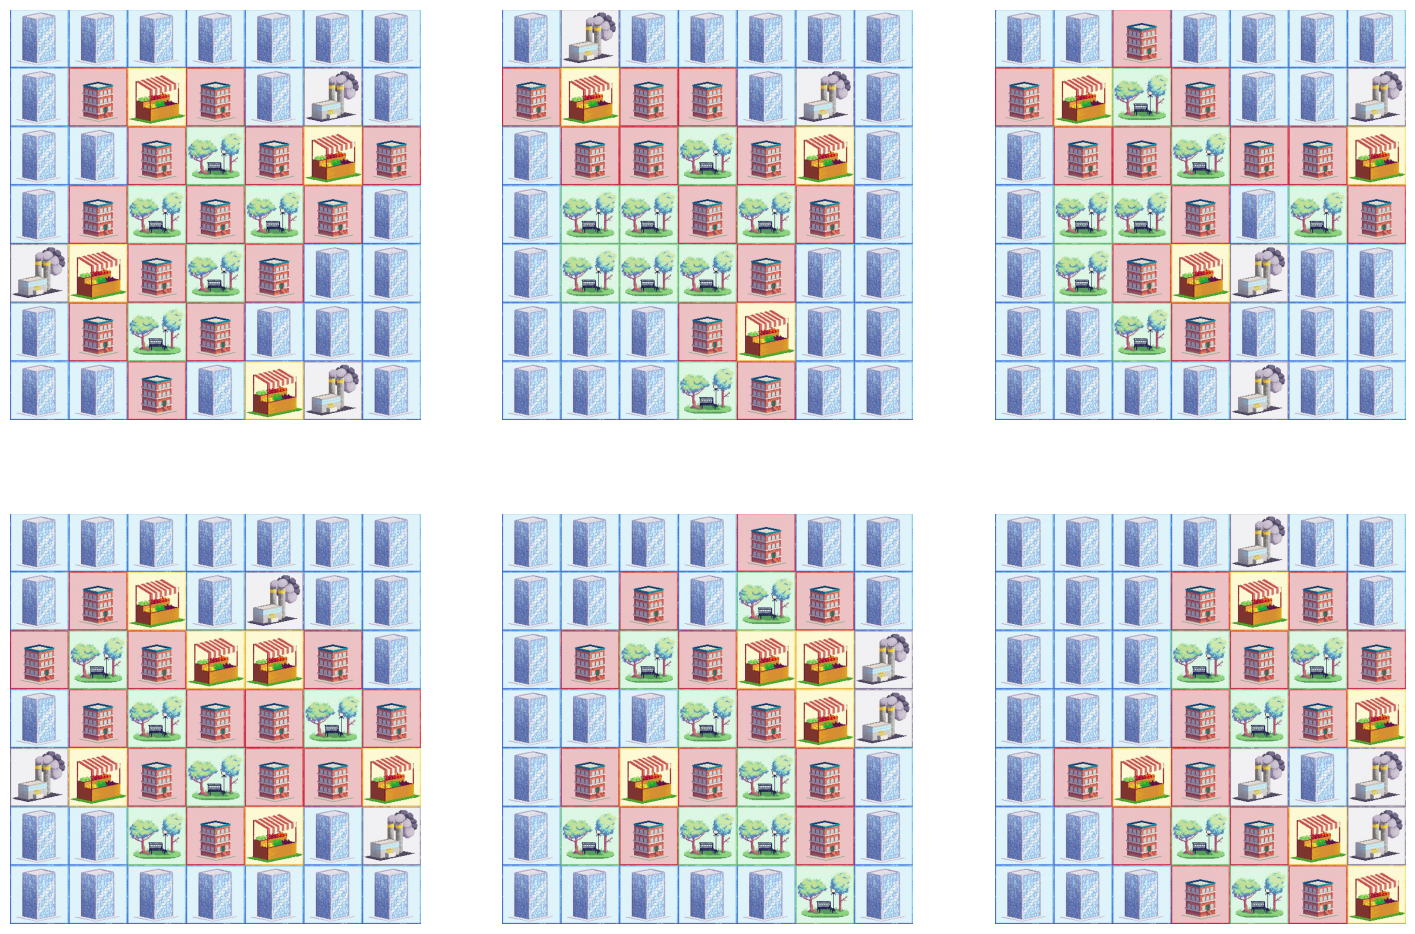

✅ Displayed top 6 grids

🎉 SUBSET ORACLE ANALYSIS COMPLETE!
📊 Found 693 valid grids out of 500,000 analyzed
💡 Validity rate: 0.14%


In [6]:
# Extract top grids from the subset analysis
print(f"\n🎯 EXTRACTING TOP GRIDS FROM SUBSET:")

# Work with the subset data we analyzed
if np.sum(valid_subset_mask) > 0:
    # Get indices of valid grids within the subset
    valid_subset_indices = np.where(valid_subset_mask)[0]
    
    # Sort by minimum score (descending)
    sorted_indices = np.argsort(min_scores_subset[valid_subset_mask])[::-1]
    
    # Get top grids (up to 100 or all valid grids, whichever is smaller)
    n_top = min(100, len(sorted_indices))
    top_subset_indices = valid_subset_indices[sorted_indices[:n_top]]
    
    # Extract the actual top grids and their predictions
    top_grids = subset_grids[top_subset_indices]
    top_predictions = subset_predictions[top_subset_indices]
    top_min_scores = min_scores_subset[valid_subset_mask][sorted_indices[:n_top]]
    
    print(f"   • Selected {len(top_grids)} grids from subset")
    print(f"   • Min score range: {np.min(top_min_scores):.4f} - {np.max(top_min_scores):.4f}")
    
    print(f"\n📊 Score ranges per advisor (top grids):")
    for i, advisor in enumerate(advisor_names):
        scores = top_predictions[:, i]
        print(f"     - {advisor:15}: {np.min(scores):.3f} - {np.max(scores):.3f}")
    
    print(f"   • Average minimum score: {np.mean(top_min_scores):.4f}")
    
    # Save the subset results
    np.save('data/submissions/oracle_subset_predictions.npy', subset_predictions)
    np.save('data/submissions/oracle_subset_min_scores.npy', min_scores_subset)
    np.save('data/submissions/oracle_subset_valid_mask.npy', valid_subset_mask)
    np.save('data/submissions/oracle_top_grids_subset.npy', top_grids)
    np.save('data/submissions/oracle_top_predictions_subset.npy', top_predictions)
    
    print(f"\n💾 Saved subset analysis results:")
    print(f"   • oracle_subset_predictions.npy")
    print(f"   • oracle_subset_min_scores.npy") 
    print(f"   • oracle_subset_valid_mask.npy")
    print(f"   • oracle_top_grids_subset.npy ({len(top_grids)} grids)")
    print(f"   • oracle_top_predictions_subset.npy")
    
    # Visualize some top grids if possible
    if len(top_grids) > 0:
        print(f"\n📊 Top grid analysis:")
        try:
            # Try to use the plotting function
            os.chdir('2155-Challenge-Problem-2')
            plot_n_grids(top_grids[-6:])  # Show top 6 grids
            os.chdir('..')
            print("✅ Displayed top 6 grids")
        except Exception as e:
            print(f"⚠️ Could not display grids: {e}")
            # Show basic stats instead
            print(f"Grid diversity example - Top grid has {len(np.unique(top_grids[-1]))} unique districts")

else:
    print("   • No valid grids found in the subset")
    print("   • Consider lowering the threshold or using a larger subset")

print(f"\n🎉 SUBSET ORACLE ANALYSIS COMPLETE!")
print(f"📊 Found {np.sum(valid_subset_mask)} valid grids out of {len(subset_predictions):,} analyzed")
print(f"💡 Validity rate: {np.sum(valid_subset_mask)/len(subset_predictions)*100:.2f}%")

In [7]:
# Save All Valid Grids and Comprehensive Results
print("💾 SAVING ALL VALID GRIDS AND COMPREHENSIVE RESULTS")
print("="*60)

# Create timestamp for unique filenames
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create data directory structure if it doesn't exist
import os
os.makedirs('data/submissions', exist_ok=True)
os.makedirs('data/models', exist_ok=True)

print(f"📁 Using timestamp: {timestamp}")

# 1. Save all oracle predictions (full dataset)
print("\n1️⃣ Saving Oracle Predictions...")
np.save(f'data/submissions/{timestamp}_oracle_predictions_full.npy', final_oracle_predictions)
np.save(f'data/submissions/{timestamp}_oracle_subset_indices.npy', subset_indices)
print(f"   ✅ Saved full oracle predictions: {final_oracle_predictions.shape}")

# 2. Save valid grids analysis
print("\n2️⃣ Saving Valid Grids Analysis...")
if 'valid_subset_mask' in locals() and np.sum(valid_subset_mask) > 0:
    # Get all valid grids from the subset
    valid_grids_subset = subset_grids[valid_subset_mask]
    valid_predictions_subset = subset_predictions[valid_subset_mask]
    valid_min_scores_subset = min_scores_subset[valid_subset_mask]
    
    # Save valid grids and their data
    np.save(f'data/submissions/{timestamp}_valid_grids.npy', valid_grids_subset)
    np.save(f'data/submissions/{timestamp}_valid_predictions.npy', valid_predictions_subset)
    np.save(f'data/submissions/{timestamp}_valid_min_scores.npy', valid_min_scores_subset)
    
    print(f"   ✅ Saved {len(valid_grids_subset):,} valid grids")
    print(f"   📊 Min score range: {np.min(valid_min_scores_subset):.4f} - {np.max(valid_min_scores_subset):.4f}")
else:
    print("   ⚠️ No valid grids found to save")

# 3. Save top performing grids
print("\n3️⃣ Saving Top Performing Grids...")
if 'top_grids' in locals() and len(top_grids) > 0:
    np.save(f'data/submissions/{timestamp}_top_grids.npy', top_grids)
    np.save(f'data/submissions/{timestamp}_top_predictions.npy', top_predictions)
    np.save(f'data/submissions/{timestamp}_top_min_scores.npy', top_min_scores)
    
    print(f"   ✅ Saved {len(top_grids)} top performing grids")
    print(f"   🏆 Best min score: {np.max(top_min_scores):.4f}")
else:
    print("   ⚠️ No top grids found to save")

# 4. Save comprehensive metadata
print("\n4️⃣ Saving Metadata and Summary...")
metadata = {
    'timestamp': timestamp,
    'total_grids': len(grids),
    'subset_size': subset_size,
    'subset_indices_shape': subset_indices.shape,
    'oracle_predictions_shape': final_oracle_predictions.shape,
    'threshold_used': threshold if 'threshold' in locals() else 0.75,
    'advisor_names': ["Wellness", "Tax", "Transportation", "Business"],
    'loaded_models': list(loaded_models.keys()) if 'loaded_models' in locals() else [],
    'data_coverage_per_advisor': (~np.isnan(final_oracle_predictions)).sum(axis=0).tolist(),
    'actual_ratings_per_advisor': (~np.isnan(ratings)).sum(axis=0).tolist()
}

if 'valid_subset_mask' in locals():
    metadata.update({
        'valid_grids_count': int(np.sum(valid_subset_mask)),
        'validity_rate': float(np.sum(valid_subset_mask)/len(subset_predictions)*100) if len(subset_predictions) > 0 else 0.0,
        'top_grids_count': len(top_grids) if 'top_grids' in locals() else 0
    })

# Save metadata as JSON
import json
with open(f'data/submissions/{timestamp}_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"   ✅ Saved metadata to {timestamp}_metadata.json")

# 5. Create summary report
print("\n5️⃣ Creating Summary Report...")
summary_lines = [
    f"ORACLE ANALYSIS SUMMARY - {timestamp}",
    "="*60,
    f"Dataset: {len(grids):,} total grids",
    f"Subset analyzed: {subset_size:,} grids ({subset_size/len(grids)*100:.1f}%)",
    f"Oracle models loaded: {len(loaded_models) if 'loaded_models' in locals() else 0}",
    "",
    "DATA COVERAGE:",
]

for i, advisor in enumerate(["Wellness", "Tax", "Transportation", "Business"]):
    coverage = (~np.isnan(final_oracle_predictions)).sum(axis=0)[i]
    percentage = (coverage / len(grids)) * 100
    summary_lines.append(f"  • {advisor:15}: {coverage:,} grids ({percentage:.1f}%)")

if 'valid_subset_mask' in locals():
    summary_lines.extend([
        "",
        "VALIDITY ANALYSIS:",
        f"  • Valid grids found: {np.sum(valid_subset_mask):,}",
        f"  • Validity rate: {np.sum(valid_subset_mask)/len(subset_predictions)*100:.2f}%",
        f"  • Threshold used: {threshold}",
    ])

if 'top_grids' in locals() and len(top_grids) > 0:
    summary_lines.extend([
        "",
        "TOP PERFORMING GRIDS:",
        f"  • Count: {len(top_grids)}",
        f"  • Best min score: {np.max(top_min_scores):.4f}",
        f"  • Score range: {np.min(top_min_scores):.4f} - {np.max(top_min_scores):.4f}",
    ])

summary_lines.extend([
    "",
    "FILES SAVED:",
    f"  • {timestamp}_oracle_predictions_full.npy",
    f"  • {timestamp}_oracle_subset_indices.npy",
])

if 'valid_subset_mask' in locals() and np.sum(valid_subset_mask) > 0:
    summary_lines.extend([
        f"  • {timestamp}_valid_grids.npy",
        f"  • {timestamp}_valid_predictions.npy", 
        f"  • {timestamp}_valid_min_scores.npy",
    ])

if 'top_grids' in locals() and len(top_grids) > 0:
    summary_lines.extend([
        f"  • {timestamp}_top_grids.npy",
        f"  • {timestamp}_top_predictions.npy",
        f"  • {timestamp}_top_min_scores.npy",
    ])

summary_lines.append(f"  • {timestamp}_metadata.json")

# Save summary
summary_text = '\n'.join(summary_lines)
with open(f'data/submissions/{timestamp}_summary.txt', 'w') as f:
    f.write(summary_text)

print(f"   ✅ Saved summary report to {timestamp}_summary.txt")

# 6. Display final summary
print(f"\n{'='*60}")
print("🎉 ALL DATA SAVED SUCCESSFULLY!")
print(f"{'='*60}")
print(f"📂 Location: data/submissions/{timestamp}_*")
print(f"📊 Total files saved: {7 + (3 if 'valid_subset_mask' in locals() and np.sum(valid_subset_mask) > 0 else 0) + (3 if 'top_grids' in locals() and len(top_grids) > 0 else 0)}")

if 'valid_subset_mask' in locals():
    print(f"✅ Valid grids: {np.sum(valid_subset_mask):,} saved")
if 'top_grids' in locals() and len(top_grids) > 0:
    print(f"🏆 Top grids: {len(top_grids)} saved")

print(f"\n💡 Use these files for:")
print(f"   • Grid optimization algorithms")
print(f"   • Submission generation")
print(f"   • Further analysis and visualization")
print(f"   • Model training and validation")

print(f"\n🔗 Quick access:")
print(f"   All grids: np.load('data/submissions/{timestamp}_oracle_predictions_full.npy')")
if 'valid_subset_mask' in locals() and np.sum(valid_subset_mask) > 0:
    print(f"   Valid grids: np.load('data/submissions/{timestamp}_valid_grids.npy')")
if 'top_grids' in locals() and len(top_grids) > 0:
    print(f"   Top grids: np.load('data/submissions/{timestamp}_top_grids.npy')")

💾 SAVING ALL VALID GRIDS AND COMPREHENSIVE RESULTS
📁 Using timestamp: 20251101_180302

1️⃣ Saving Oracle Predictions...
   ✅ Saved full oracle predictions: (500000, 4)

2️⃣ Saving Valid Grids Analysis...
   ✅ Saved 693 valid grids
   📊 Min score range: 0.7503 - 0.9721

3️⃣ Saving Top Performing Grids...
   ✅ Saved 100 top performing grids
   🏆 Best min score: 0.9721

4️⃣ Saving Metadata and Summary...
   ✅ Saved metadata to 20251101_180302_metadata.json

5️⃣ Creating Summary Report...
   ✅ Saved summary report to 20251101_180302_summary.txt

🎉 ALL DATA SAVED SUCCESSFULLY!
📂 Location: data/submissions/20251101_180302_*
📊 Total files saved: 13
✅ Valid grids: 693 saved
🏆 Top grids: 100 saved

💡 Use these files for:
   • Grid optimization algorithms
   • Submission generation
   • Further analysis and visualization
   • Model training and validation

🔗 Quick access:
   All grids: np.load('data/submissions/20251101_180302_oracle_predictions_full.npy')
   Valid grids: np.load('data/submissio